# Linear Models

## Load Data

In [62]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from skimage import color
import tensorflow as tf
import cv2
from keras.applications import VGG19

In [56]:
images_train_raw = np.load("../data/images/images_train.npy") / 255.0
images_test_raw = np.load("../data/images/images_test.npy") / 255.0

hog_train_raw = np.load("../data/hog/hog_train.npy") * 255
hog_test_raw = np.load("../data/hog/hog_test.npy") * 255

canny_edges_train_raw  = np.load("../data/canny_edges/canny_edges_train.npy")
canny_edges_test_raw  = np.load("../data/canny_edges/canny_edges_test.npy")

contours_train_raw = np.load("../data/contours/contours_train.npy")
contours_test_raw = np.load("../data/contours/contours_test.npy")

vgg19_train_raw = np.load('../data/vgg19/vgg19_train.npy')
vgg19_test_raw = np.load('../data/vgg19/vgg19_test.npy')

cropped_train_raw = np.load('../data/bounding_boxes/bounding_boxes_train.npy')
cropped_test_raw = np.load('../data/bounding_boxes/bounding_boxes_test.npy')

y_train = np.load("../data/images/label_ids_train.npy")
y_test = np.load("../data/images/label_ids_test.npy")

### Convert to Grayscale

In [57]:
images_train_gray = np.array([color.rgb2gray(image) for image in images_train_raw])
images_test_gray = np.array([color.rgb2gray(image) for image in images_test_raw])

cropped_train_gray = np.array([color.rgb2gray(image) for image in cropped_train_raw])
cropped_test_gray = np.array([color.rgb2gray(image) for image in cropped_test_raw])

### Flatten Feature Arrays

In [58]:
images_train = np.array([image.flatten() for image in images_train_gray])
images_test = np.array([image.flatten() for image in images_test_gray])

hog_train = np.array([image.flatten() for image in hog_train_raw])
hog_test = np.array([image.flatten() for image in hog_test_raw])

canny_edges_train = np.array([image.flatten() for image in canny_edges_train_raw])
canny_edges_test = np.array([image.flatten() for image in canny_edges_test_raw])

contours_train = np.array([image.flatten() for image in contours_train_raw])
contours_test = np.array([image.flatten() for image in contours_test_raw])

vgg19_train = np.array([image.flatten() for image in vgg19_train_raw])
vgg19_test = np.array([image.flatten() for image in vgg19_test_raw])

cropped_train = np.array([image.flatten() for image in cropped_train_gray])
cropped_test = np.array([image.flatten() for image in cropped_test_gray])

In [8]:
class_lookup = {0: 'spiral', 1: 'greenstick', 2: 'comminuted', 3: 'avulsion'}
sorted_class_lookup = {k: class_lookup[k] for k in sorted(class_lookup)}
label_names = list(sorted_class_lookup.values())
label_names

['spiral', 'greenstick', 'comminuted', 'avulsion']

In [9]:
def show_confusion_matrix(confusion_matrix):
  ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                  xticklabels=label_names, yticklabels=label_names, cbar=False)

  # Add axis labels.
  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.show()

In [14]:
def show_roc_curve(y_score, y_test):
  # Binarize the output
  y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
  n_classes = y_test_bin.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(n_classes):
      plt.figure()
      plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic for {label_names[i]}')
      plt.legend(loc="lower right")
      plt.show()

## Model 1: Images Only

In [11]:
model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
model.fit(images_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

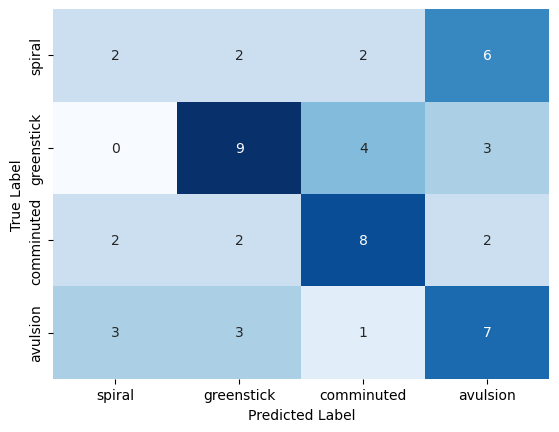

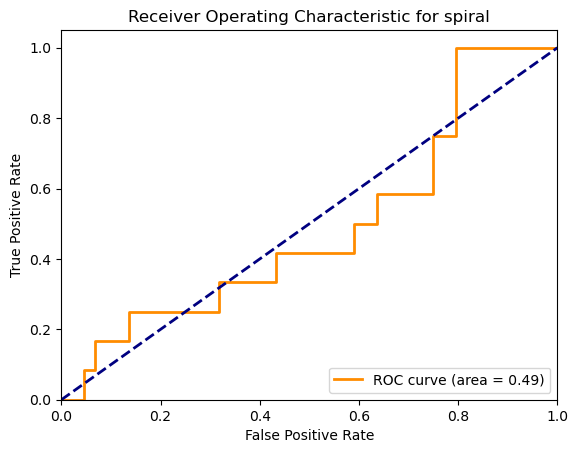

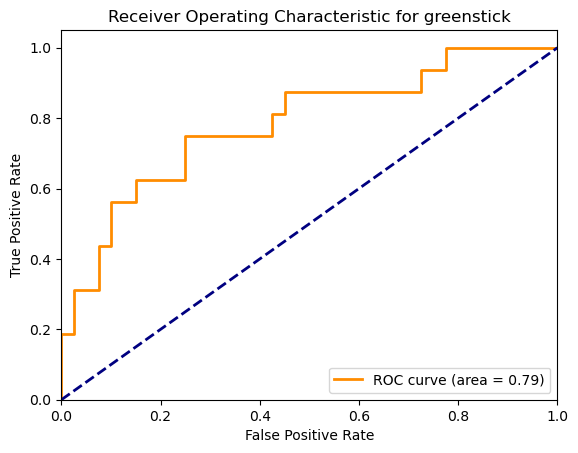

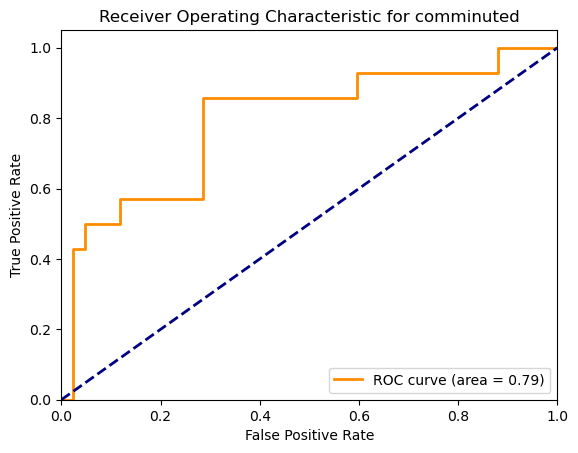

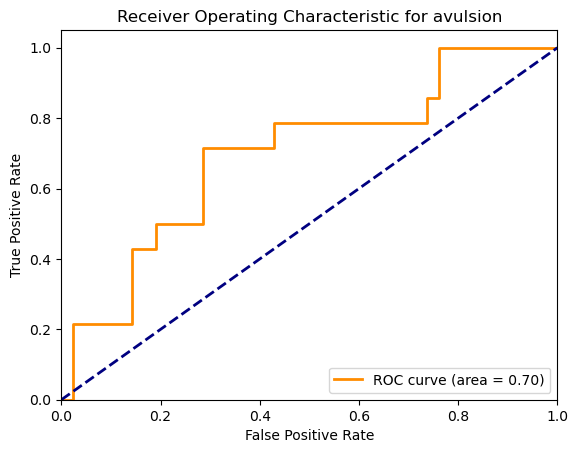

Accuracy: 0.4642857142857143
Classification Report:


,precision,recall,f1-score,support
spiral,0.285714,0.166667,0.210526,12.000000
greenstick,0.562500,0.562500,0.562500,16.000000
comminuted,0.533333,0.571429,0.551724,14.000000
avulsion,0.388889,0.500000,0.437500,14.000000
accuracy,0.464286,0.464286,0.464286,0.464286
macro avg,0.442609,0.450149,0.440563,56.000000
weighted avg,0.452494,0.464286,0.453133,56.000000


In [15]:
y_pred = model.predict(images_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(images_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 2: HOG Feature Only

In [16]:
images_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
images_model.fit(hog_train, y_train)


LogisticRegression(max_iter=1000)

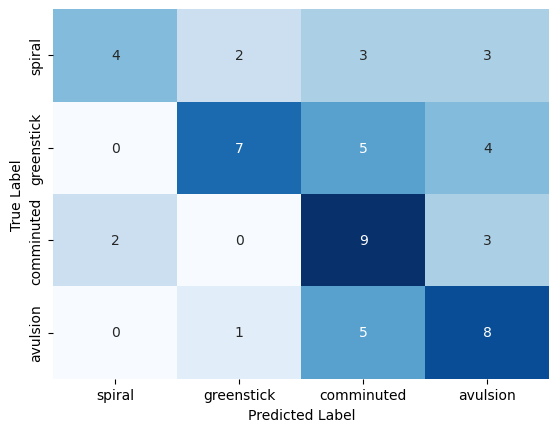

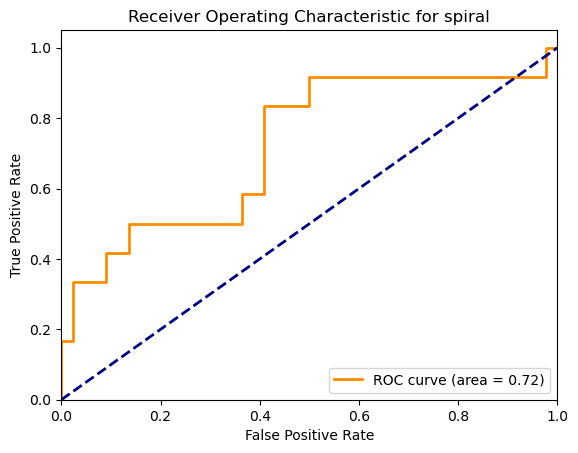

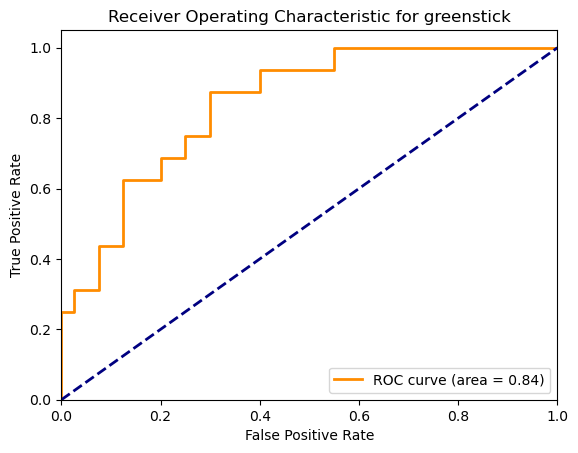

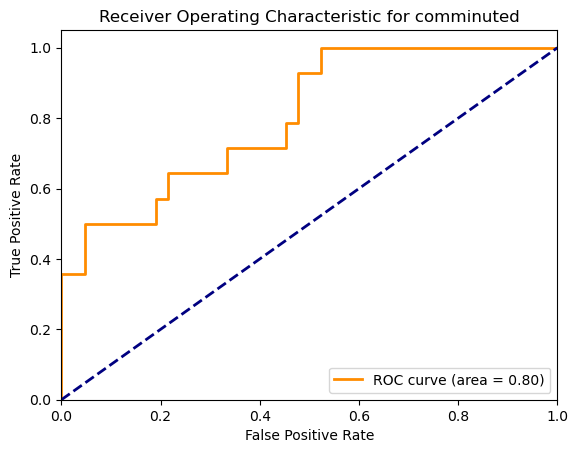

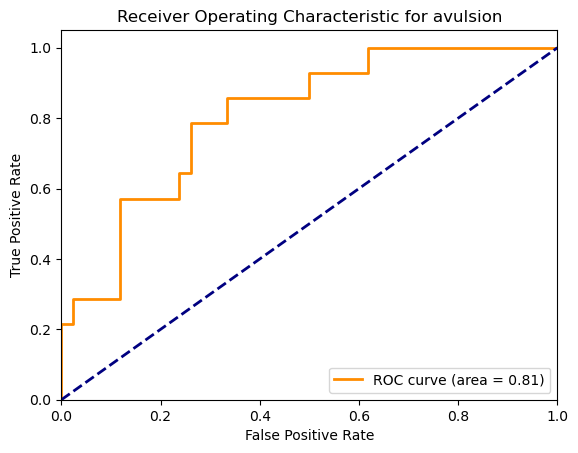

Accuracy: 0.5
Classification Report:


,precision,recall,f1-score,support
spiral,0.666667,0.333333,0.444444,12.0
greenstick,0.700000,0.437500,0.538462,16.0
comminuted,0.409091,0.642857,0.500000,14.0
avulsion,0.444444,0.571429,0.500000,14.0
accuracy,0.500000,0.500000,0.500000,0.5
macro avg,0.555051,0.496280,0.495726,56.0
weighted avg,0.556241,0.500000,0.499084,56.0


In [17]:
y_pred = images_model.predict(hog_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(hog_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 3: Canny Edges Feature Only

In [18]:
images_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
images_model.fit(canny_edges_train, y_train)


LogisticRegression(max_iter=1000)

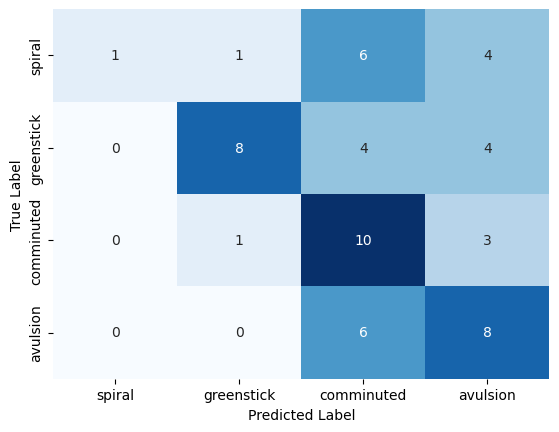

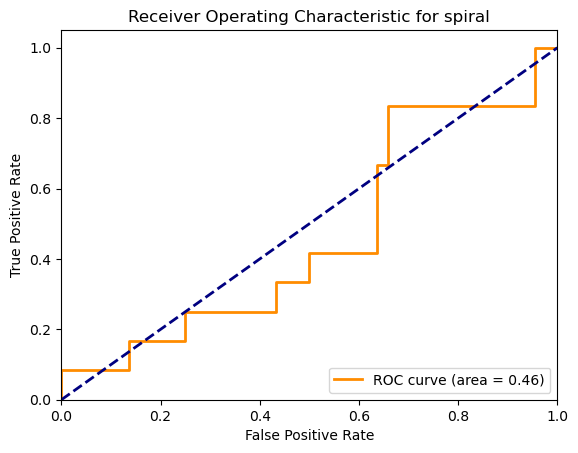

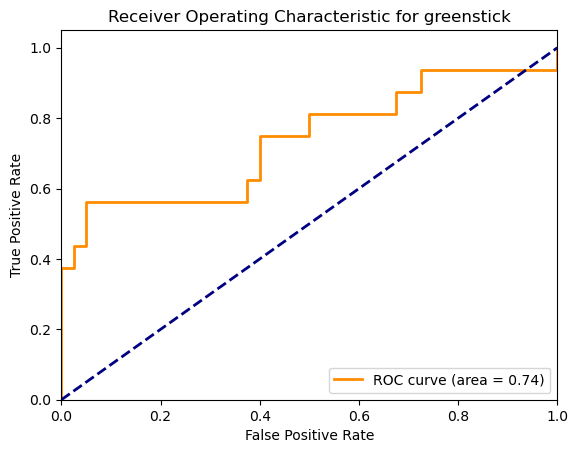

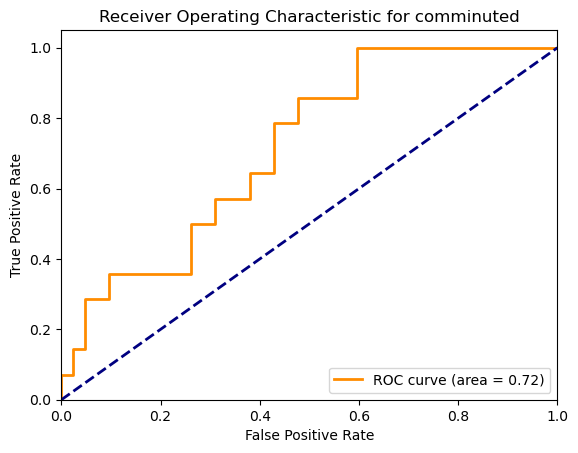

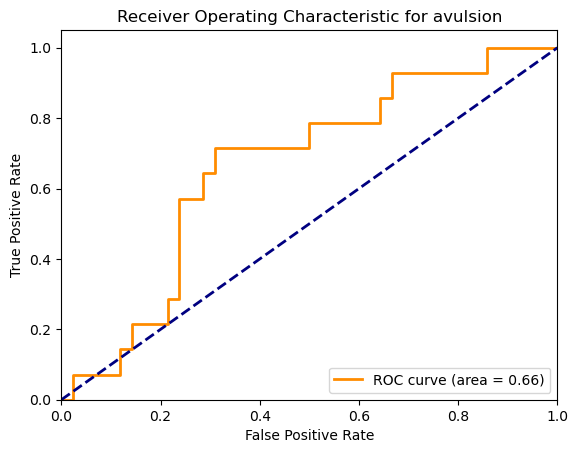

Accuracy: 0.48214285714285715
Classification Report:


,precision,recall,f1-score,support
spiral,1.000000,0.083333,0.153846,12.000000
greenstick,0.800000,0.500000,0.615385,16.000000
comminuted,0.384615,0.714286,0.500000,14.000000
avulsion,0.421053,0.571429,0.484848,14.000000
accuracy,0.482143,0.482143,0.482143,0.482143
macro avg,0.651417,0.467262,0.438520,56.000000
weighted avg,0.644274,0.482143,0.455003,56.000000


In [19]:
y_pred = images_model.predict(canny_edges_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(canny_edges_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 4: Contours Feature Only

In [25]:
contours_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
contours_model.fit(contours_train, y_train)


LogisticRegression(max_iter=1000)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


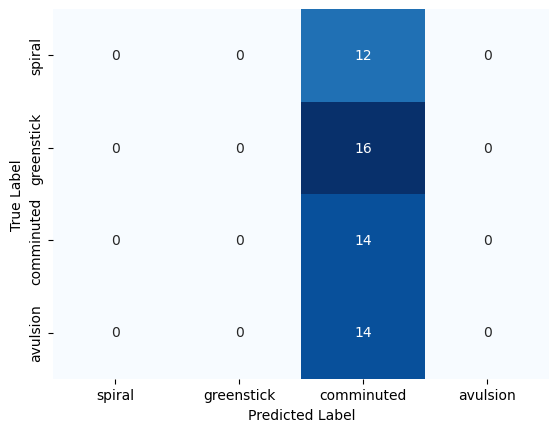

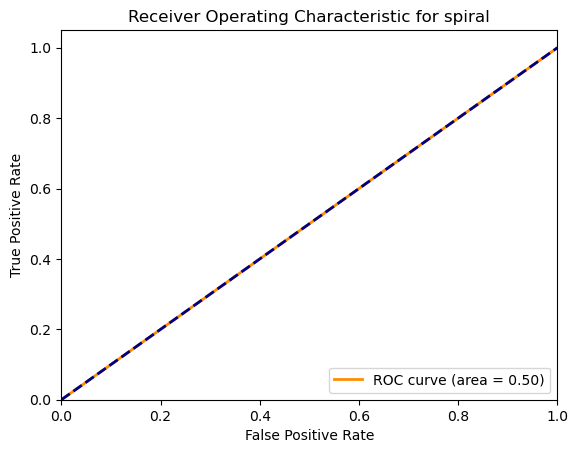

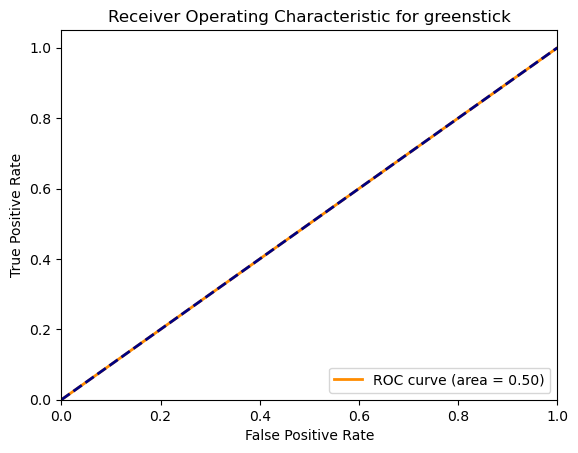

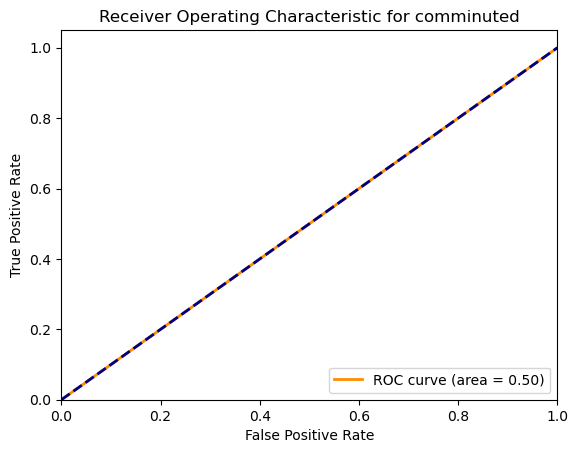

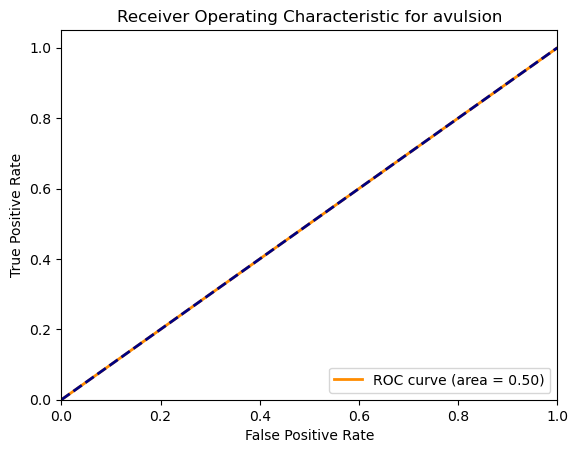

Accuracy: 0.25
Classification Report:


,precision,recall,f1-score,support
spiral,0.0000,0.00,0.00,12.00
greenstick,0.0000,0.00,0.00,16.00
comminuted,0.2500,1.00,0.40,14.00
avulsion,0.0000,0.00,0.00,14.00
accuracy,0.2500,0.25,0.25,0.25
macro avg,0.0625,0.25,0.10,56.00
weighted avg,0.0625,0.25,0.10,56.00


In [30]:
y_pred = contours_model.predict(contours_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = contours_model.predict_proba(contours_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 5: VGG 19

In [31]:
images_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
images_model.fit(vgg19_train, y_train)

LogisticRegression(max_iter=1000)

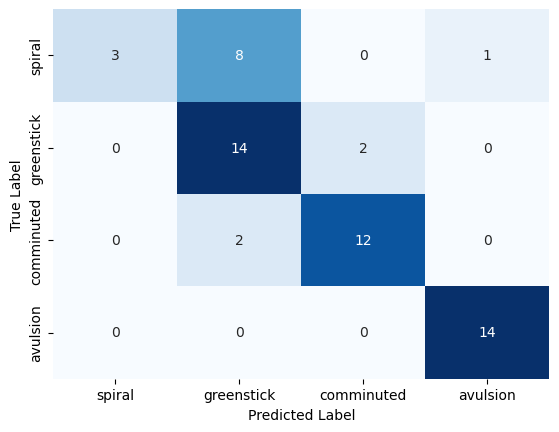

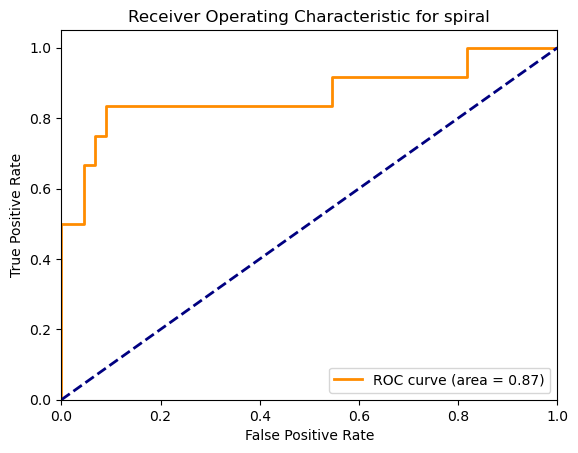

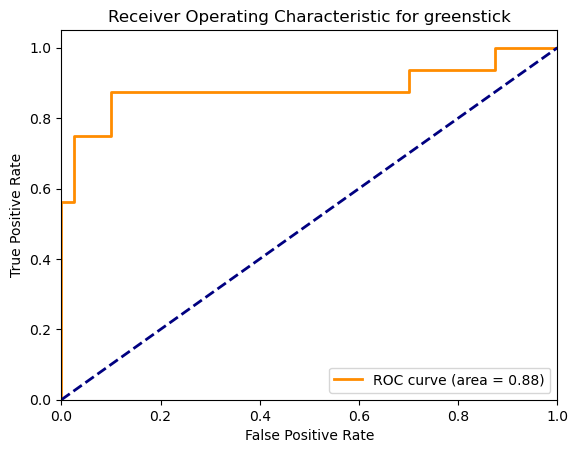

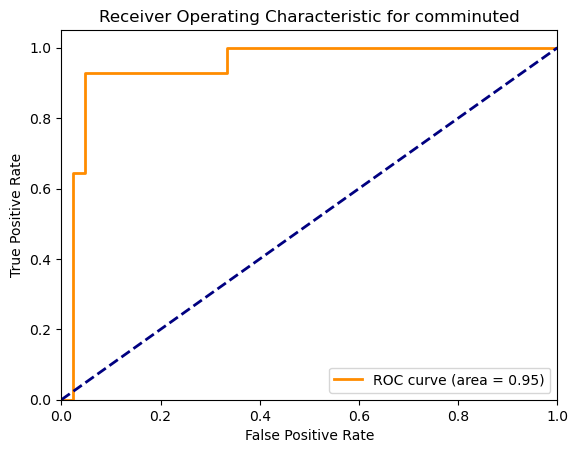

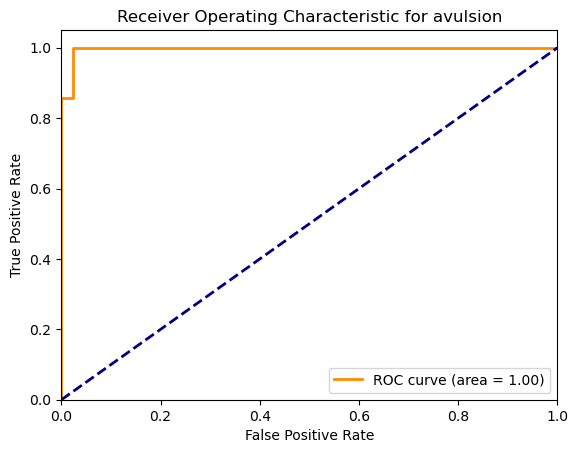

Accuracy: 0.7678571428571429
Classification Report:


,precision,recall,f1-score,support
spiral,1.000000,0.250000,0.400000,12.000000
greenstick,0.583333,0.875000,0.700000,16.000000
comminuted,0.857143,0.857143,0.857143,14.000000
avulsion,0.933333,1.000000,0.965517,14.000000
accuracy,0.767857,0.767857,0.767857,0.767857
macro avg,0.843452,0.745536,0.730665,56.000000
weighted avg,0.828571,0.767857,0.741379,56.000000


In [35]:
y_pred = images_model.predict(vgg19_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(vgg19_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 6: Cropped Images

In [60]:
images_model = LogisticRegression(max_iter=2000, multi_class='auto', solver='lbfgs')
images_model.fit(cropped_train, y_train)

LogisticRegression(max_iter=2000)

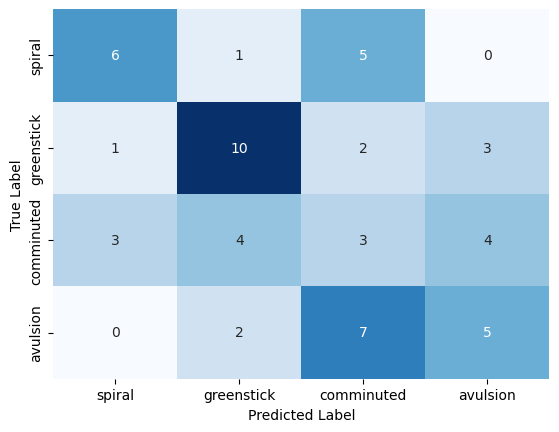

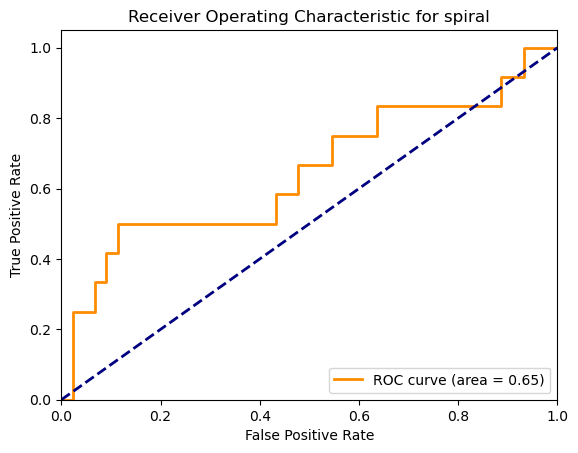

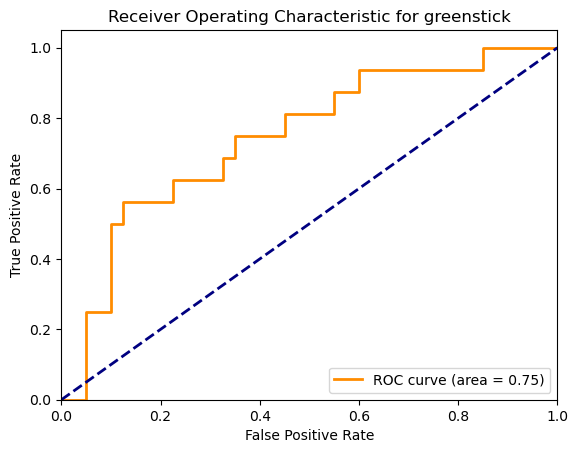

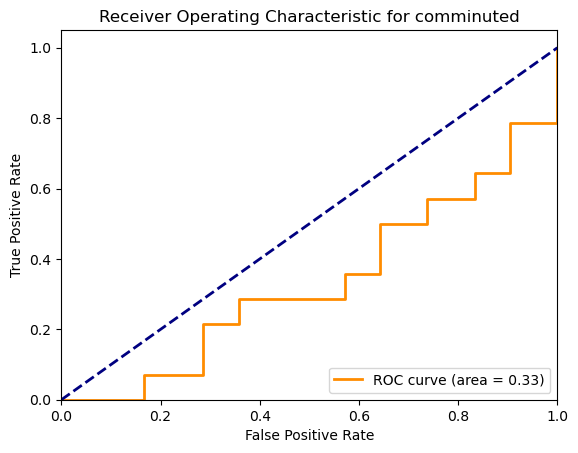

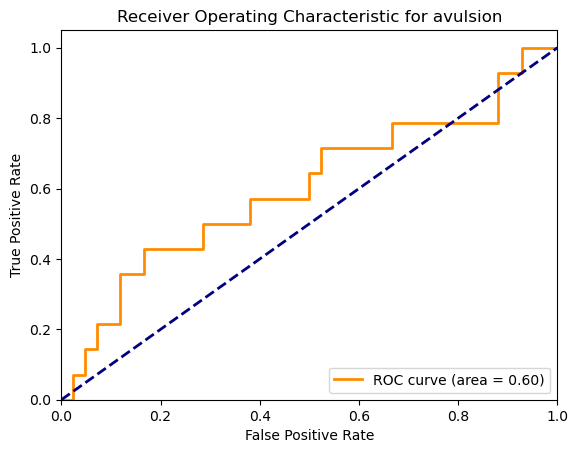

Accuracy: 0.42857142857142855
Classification Report:


,precision,recall,f1-score,support
spiral,0.600000,0.500000,0.545455,12.000000
greenstick,0.588235,0.625000,0.606061,16.000000
comminuted,0.176471,0.214286,0.193548,14.000000
avulsion,0.416667,0.357143,0.384615,14.000000
accuracy,0.428571,0.428571,0.428571,0.428571
macro avg,0.445343,0.424107,0.432420,56.000000
weighted avg,0.444923,0.428571,0.434584,56.000000


In [61]:
y_pred = images_model.predict(cropped_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(cropped_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

In [65]:
model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

features_train_raw = []
for img in cropped_train_raw:
    features_train_raw.append(model.predict(img.reshape((1, 128, 128, 3))))

features_train_raw = np.array(features_train_raw)

features_test_raw = []
for img in cropped_test_raw:
    features_test_raw.append(model.predict(img.reshape((1, 128, 128, 3))))

features_test_raw = np.array(features_test_raw)

features_train = np.array([image.flatten() for image in features_train_raw])
features_test = np.array([image.flatten() for image in features_test_raw])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [67]:
images_model = LogisticRegression(max_iter=2000, multi_class='auto', solver='lbfgs')
images_model.fit(features_train, y_train)

LogisticRegression(max_iter=2000)

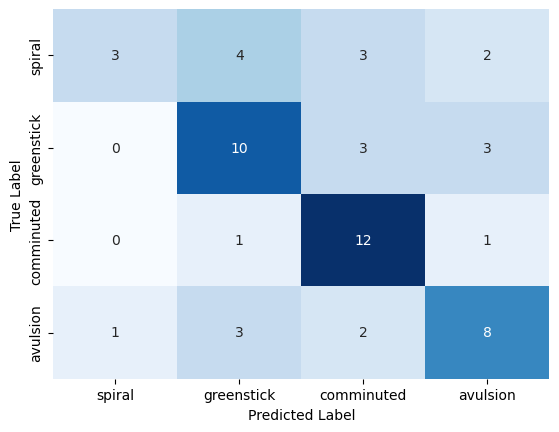

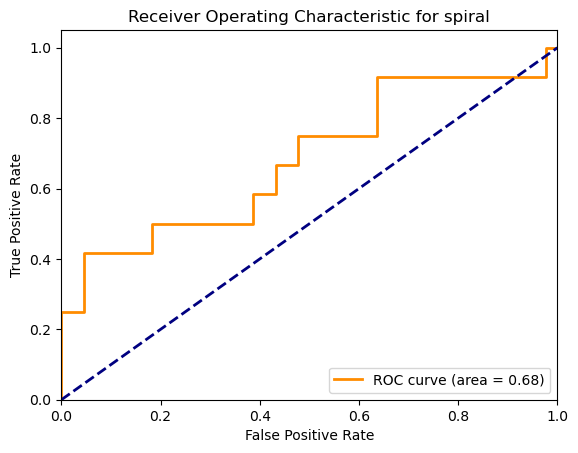

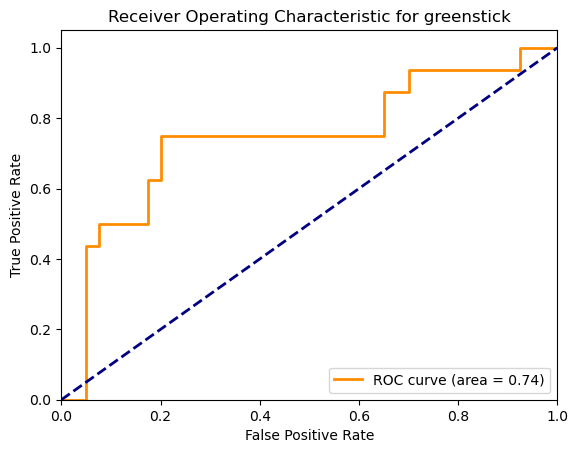

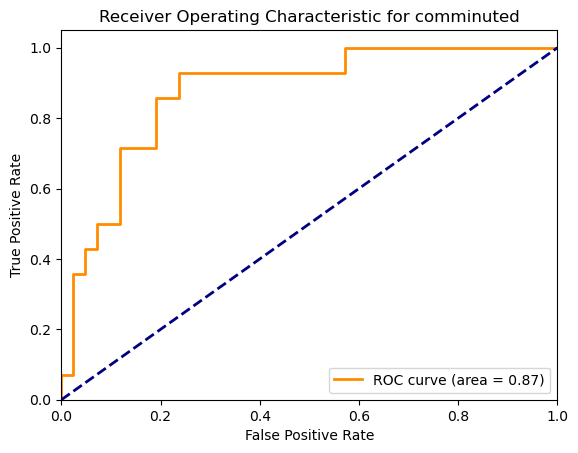

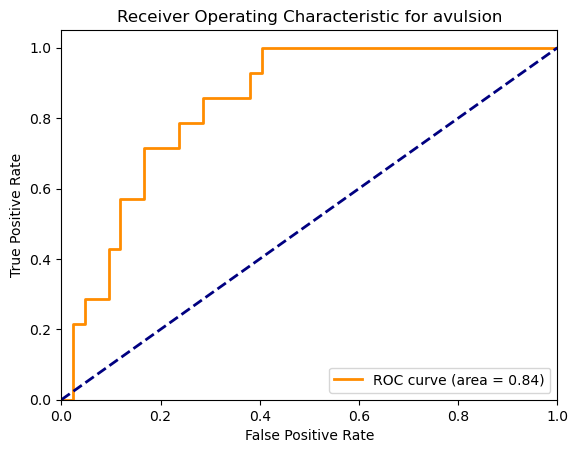

Accuracy: 0.5892857142857143
Classification Report:


,precision,recall,f1-score,support
spiral,0.750000,0.250000,0.375000,12.000000
greenstick,0.555556,0.625000,0.588235,16.000000
comminuted,0.600000,0.857143,0.705882,14.000000
avulsion,0.571429,0.571429,0.571429,14.000000
accuracy,0.589286,0.589286,0.589286,0.589286
macro avg,0.619246,0.575893,0.560137,56.000000
weighted avg,0.612302,0.589286,0.567752,56.000000


In [68]:
y_pred = images_model.predict(features_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(features_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 7: Best Combination

In [69]:
X_train = np.hstack((features_train, vgg19_train))
X_test = np.hstack((features_test, vgg19_test))

In [70]:
images_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
images_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

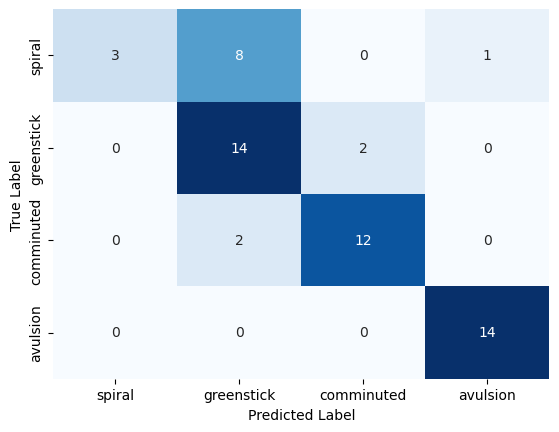

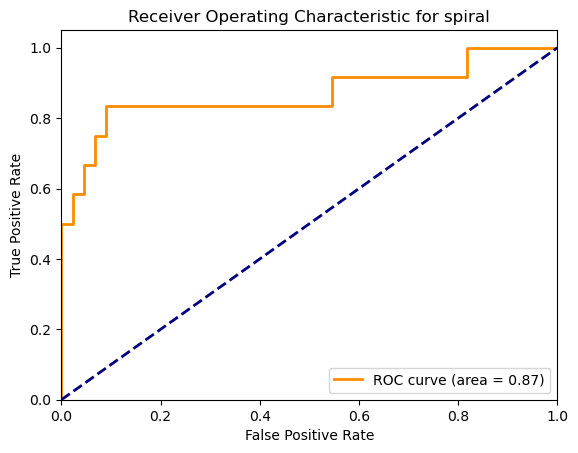

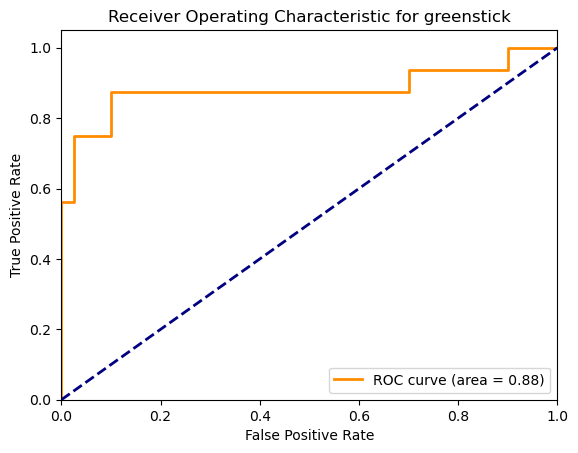

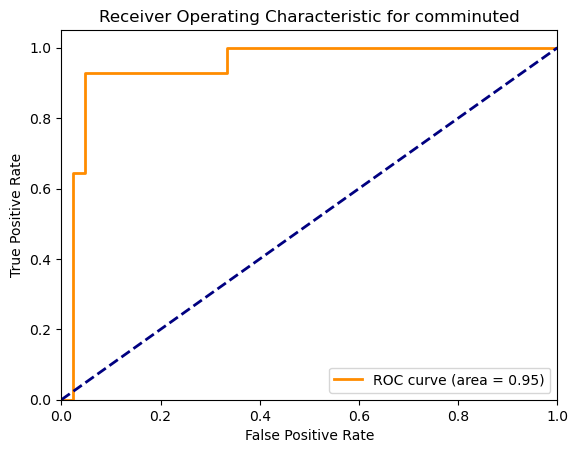

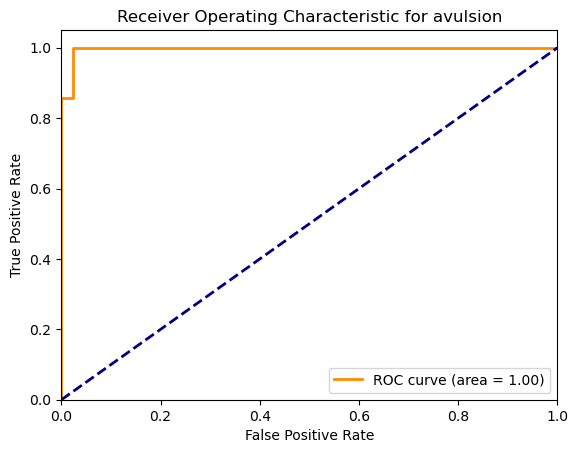

Accuracy: 0.7678571428571429
Classification Report:


,precision,recall,f1-score,support
spiral,1.000000,0.250000,0.400000,12.000000
greenstick,0.583333,0.875000,0.700000,16.000000
comminuted,0.857143,0.857143,0.857143,14.000000
avulsion,0.933333,1.000000,0.965517,14.000000
accuracy,0.767857,0.767857,0.767857,0.767857
macro avg,0.843452,0.745536,0.730665,56.000000
weighted avg,0.828571,0.767857,0.741379,56.000000


In [71]:
y_pred = images_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = images_model.predict_proba(X_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report